In [114]:
# automatically load changes from the sandbox_steps module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import sys
import os
from e2b_desktop import Sandbox, CommandExitException
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.abspath('..')) # Add the parent directory (project root) to sys.path

from counter_strike.install_cs import install_cs_1_6, connect_to_server, choose_team
from counter_strike.image_handling import get_screenshot_message, draw_point, get_screenshot
from counter_strike.agent import run_agent, AgentSettings

from llms.models import AimingModel, OpenRouterGameplayModel
from llms.tools import MoveTool

E2B_API_KEY = os.environ.get("E2B_API_KEY")
CS_SERVER_IP = os.environ.get("CS_SERVER_IP")


In [131]:
# With custom configuration
desktop = Sandbox(
    display=":0",  # Custom display (defaults to :0)
    resolution=(1920, 1080),  # Custom resolution
    timeout = 3600) 

desktop.stream.start()

# Get stream URL
url = desktop.stream.get_url()
print(url)

# only viewing 
url_view = desktop.stream.get_url(view_only=True)
print(url_view)

https://6080-ibc1htb9x98s7l11myipm-9b07d41d.e2b.app/vnc.html?autoconnect=true&resize=scale
https://6080-ibc1htb9x98s7l11myipm-9b07d41d.e2b.app/vnc.html?autoconnect=true&view_only=true&resize=scale


In [132]:
agent_setting = AgentSettings(
    side = "CT",
    open_router_api_key_name="OPENROUTER_API_KEY"
)

install_cs_1_6(desktop=desktop)
connect_to_server(desktop=desktop, ip_address=CS_SERVER_IP)
choose_team(desktop=desktop,
            team_option=agent_setting.team_choice,
            skin=agent_setting.skin_choice)

Waiting for 150 secs for map download...


In [189]:
aiming_model = AimingModel(#model="qwen/qwen2.5-vl-72b-instruct",
                           system_message=agent_setting.aiming_system_prompt,
                           api_key_name=agent_setting.open_router_key_name)

move_tool = MoveTool(desktop=desktop)
tools = {move_tool.name: move_tool}

gameplay_model = OpenRouterGameplayModel(tools=tools, 
                                         #model="openai/gpt-4.1-nano",
                                         #model="google/gemini-2.0-flash-lite-001",
                                         #model="openai/gpt-4o",
                                         api_key_name=agent_setting.open_router_key_name)

In [190]:
history = run_agent(aiming_model=aiming_model,
            gameplay_model=gameplay_model,
            desktop=desktop,
            iterations=3,
            memory_capacity=0,
            image_logging_path="../images") # For demonstration 

ImageLoggingSettings: Session directory created at ../images\20250513_010754

--- Iteration 1 ---


RuntimeError: Attempted to access 'response.content' on a streaming response. Call 'response.read()' first.

[{'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': ''}}]}]
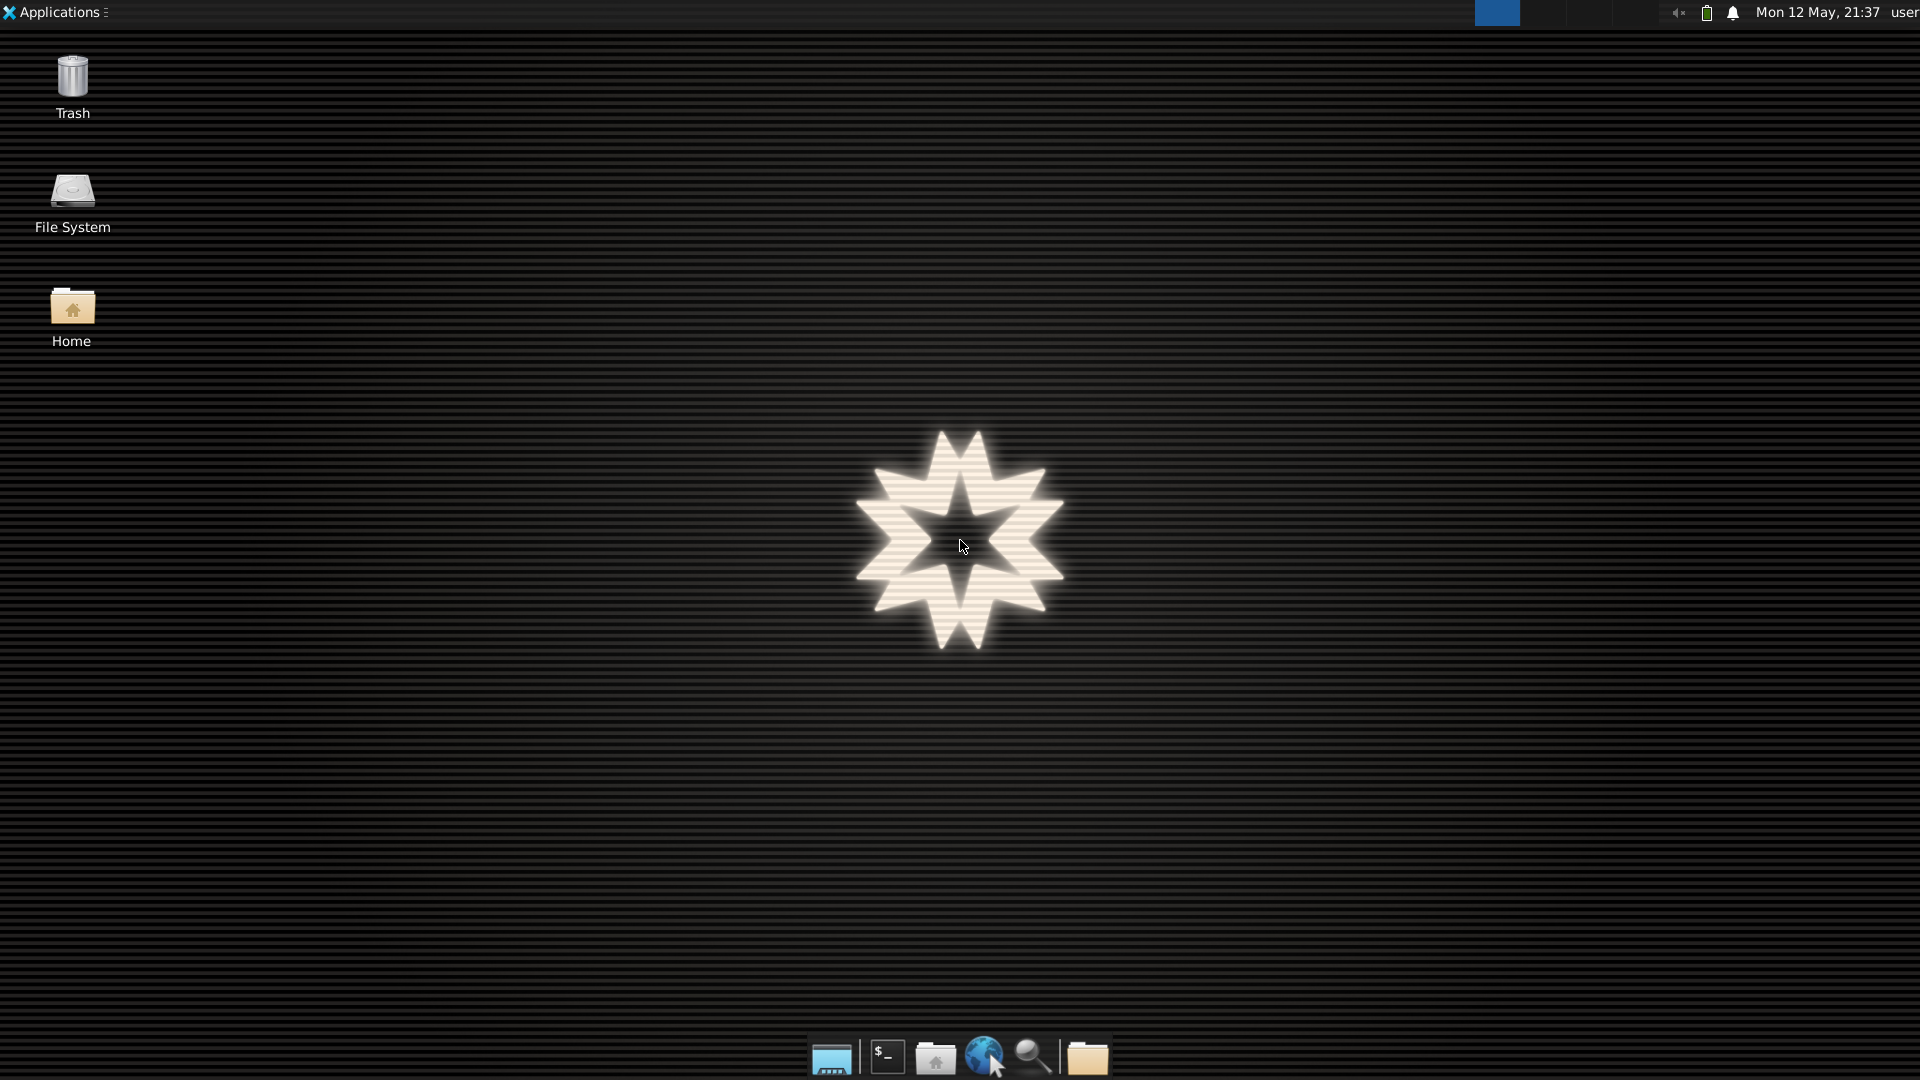

In [89]:
screenshot_message = get_screenshot_message(desktop)[0]
screenshot_message

[{'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'image_url',
  'image_url': {'url': ''}}]
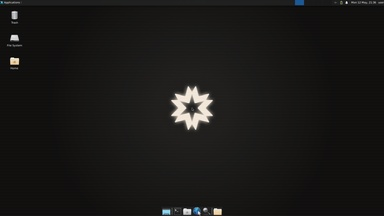
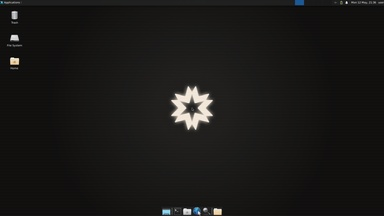

In [90]:
from counter_strike.agent import combine_screenshot_message_with_image_history
image_messages = memory.get_image_memory()
image_messages

[{'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': ''}},
   {'type': 'image_url',
    'image_url': {'url': ''}},
   {'type': 'image_url',
    'image_url': {'url': ''}}]}]
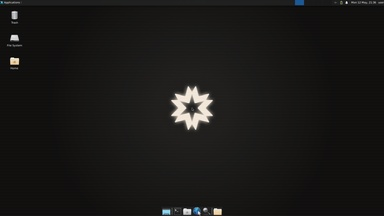
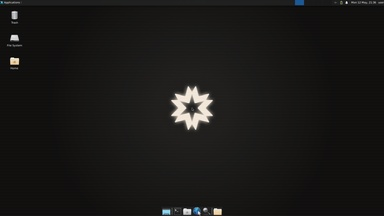
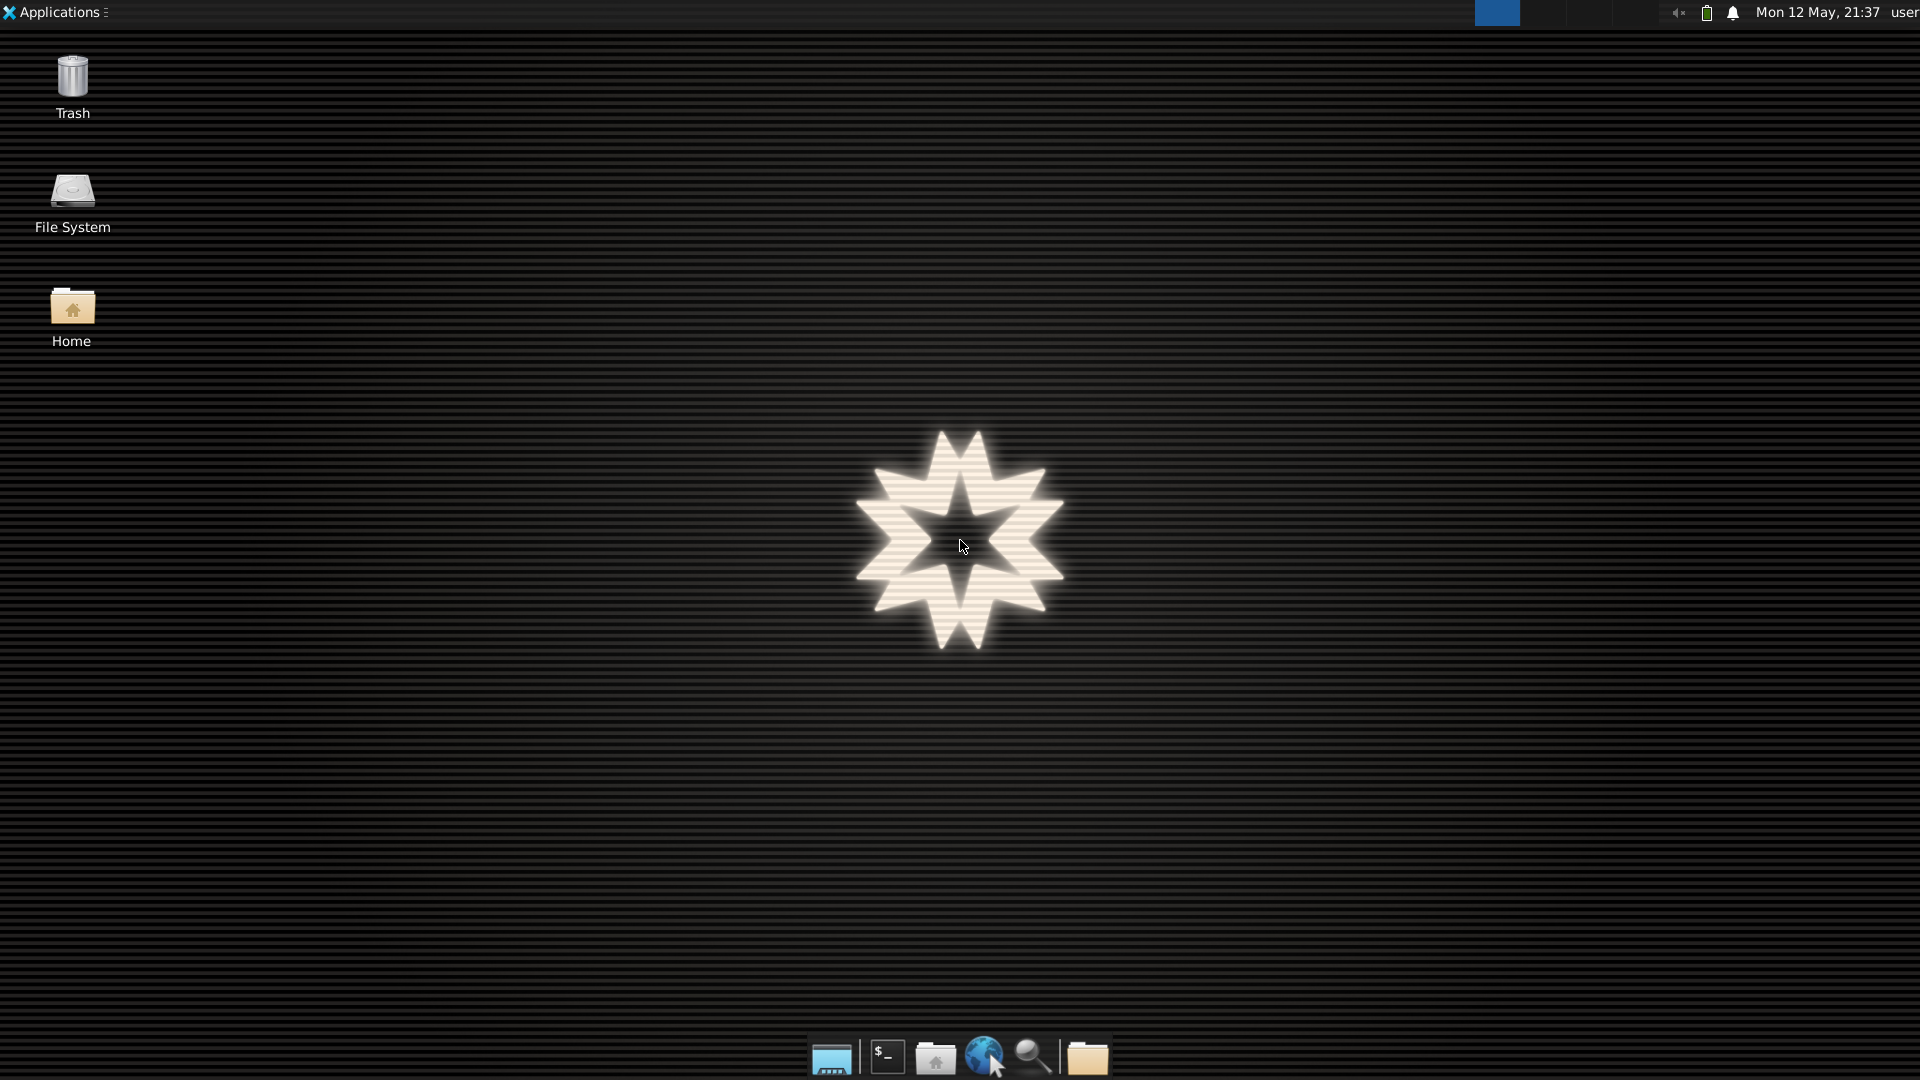

In [91]:
combined_images = combine_screenshot_message_with_image_history(image_history_messages=image_messages,
                                              screenshot_message=screenshot_message)
combined_images

In [92]:
action_messages = memory.get_action_memory()
action_messages

[{'role': 'assistant', 'content': 'No Action'},
 {'role': 'assistant', 'content': 'No Action'}]

[{'role': 'assistant', 'content': 'No Action'},
 {'role': 'assistant', 'content': 'No Action'},
 {'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': ''}},
   {'type': 'image_url',
    'image_url': {'url': ''}},
   {'type': 'image_url',
    'image_url': {'url': ''}}]}]
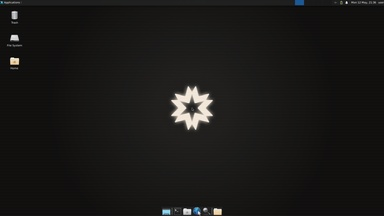
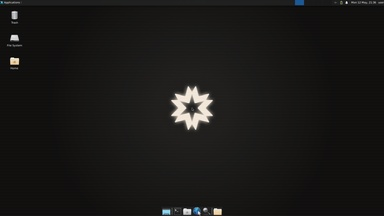
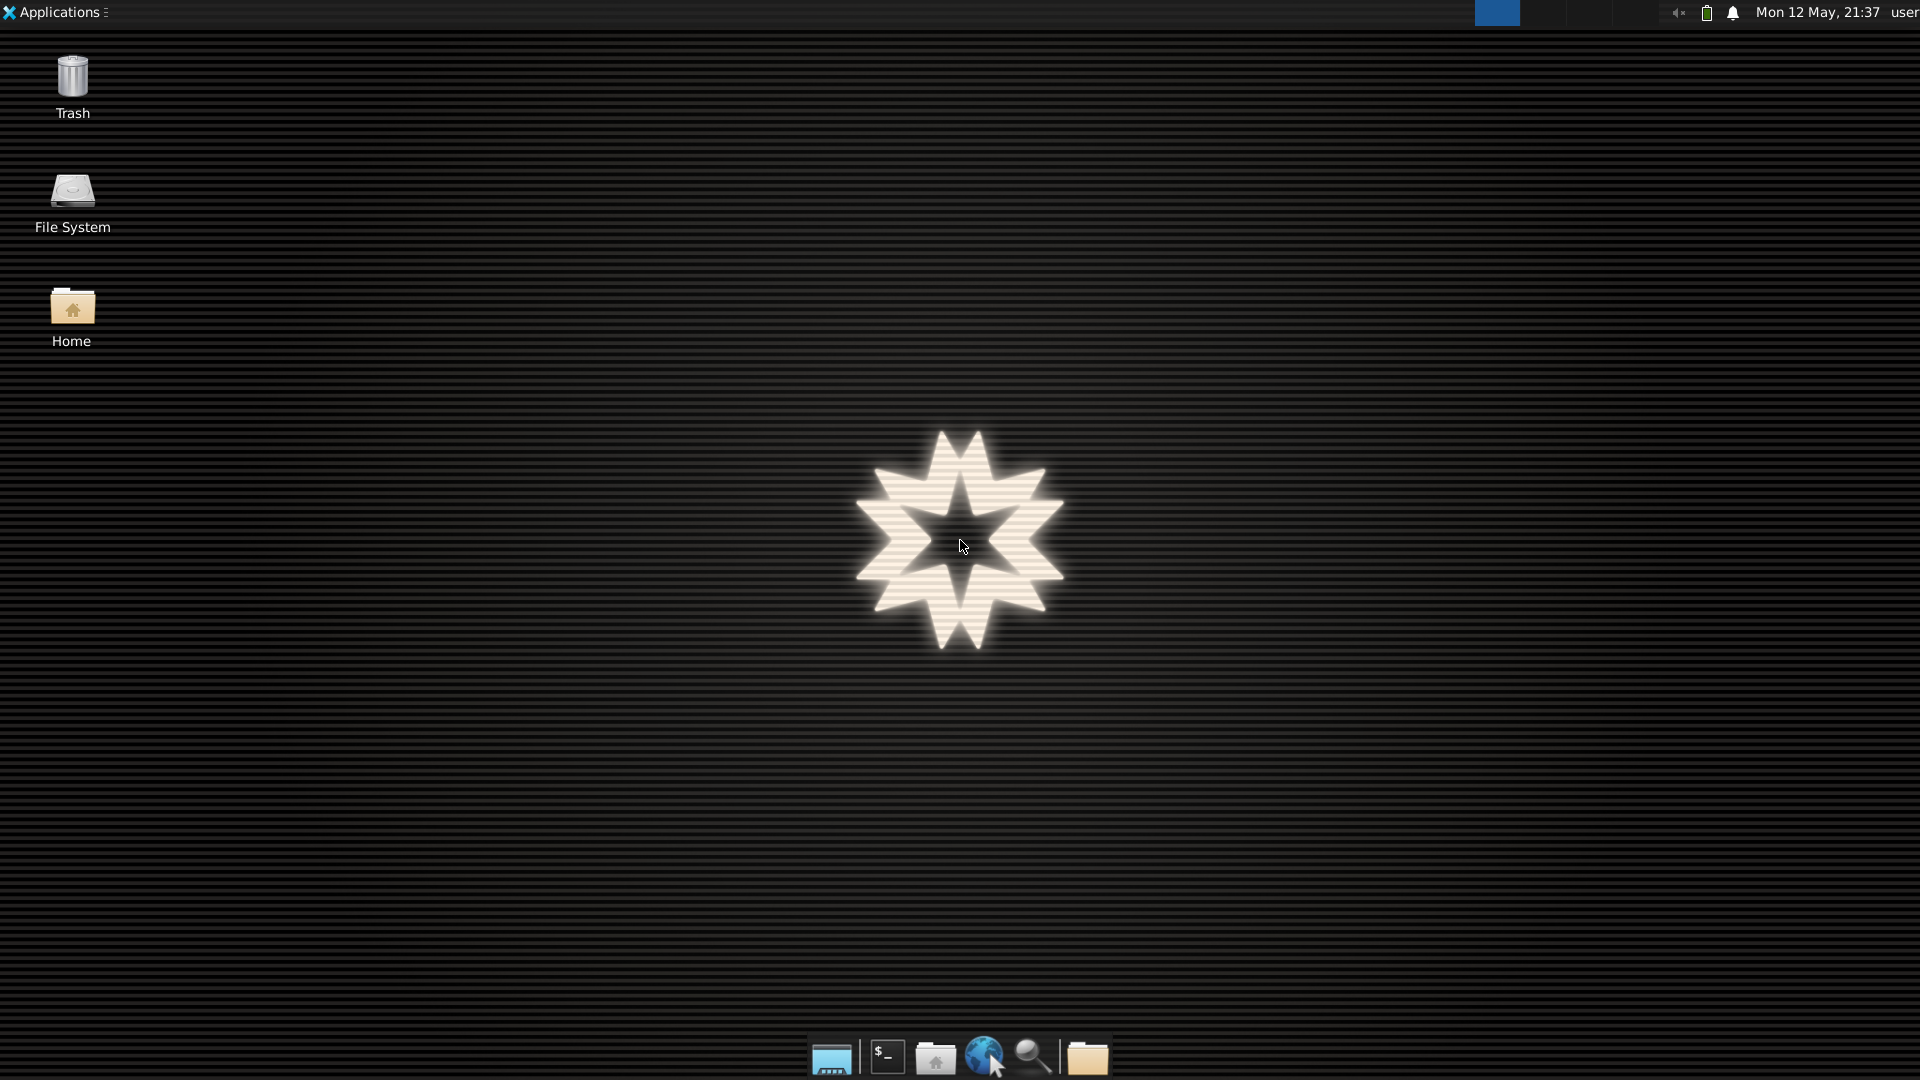

In [93]:
all_messages = action_messages + combined_images
all_messages

In [83]:
gameplay_model.complete(combined_images)

('Based on the images, the main difference is the browser being used. The first two images show the Google Chrome browser, while the third image shows the Mozilla Firefox browser.',
 ChatCompletion(id='gen-1747085684-lY5GDFW9LRXxLoSOG2Io', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Based on the images, the main difference is the browser being used. The first two images show the Google Chrome browser, while the third image shows the Mozilla Firefox browser.', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='STOP')], created=1747085684, model='google/gemini-2.5-flash-preview', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=34, prompt_tokens=952, total_tokens=986, completion_tokens_details=None, prompt_tokens_details=None), provider='Google'),
 None)

deque([([{'role': 'assistant',
          'content': 'Action taken move_tool, with the sequence: {"key_sequence":"wwddd"}'}],
        [{'role': 'user',
          'content': [{'type': 'image_url',
            'image_url': {'url': ''}}]}]),
       ([{'role': 'assistant', 'content': 'No Action'}],
        [{'role': 'user',
          'content': [{'type': 'image_url',
            'image_url': {'url': ''}}]}])],
      maxlen=2)
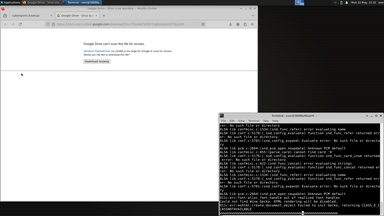
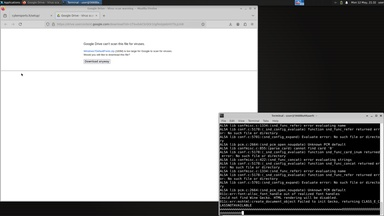

In [84]:
memory.iterations

In [65]:
#desktop.write(text="ddddddddddddddddd", delay_in_ms=0, chunk_size=50)
desktop.write(text="dddddddddddddddddddd")
desktop.write(text="aaaaaaaaaaaaaaaaaaaa")
desktop.write(text="wwwwwwwwwwwwwwwwwwww")

In [29]:
desktop.move_mouse(1380, 540) # keep y constant
#desktop.move_mouse(540, 540) 

In [3]:
desktop.kill()

In [4]:
from counter_strike.image_handling import get_mouse_movements
from counter_strike.controls import aim, shoot

from llms.models import AimingModel

aiming_model = AimingModel()

In [5]:
screenshot_message = get_screenshot_message(desktop)

In [6]:
aiming_model.complete(screenshot_message)

Model: qwen/qwen2.5-vl-32b-instruct
Provider: Fireworks


('```json\n{"point": {"x": "966", "y": "544"}}\n```',
 ChatCompletion(id='gen-1746964059-5JTwSxoL0nQbgLaUaWa9', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{"point": {"x": "966", "y": "544"}}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], created=1746964059, model='qwen/qwen2.5-vl-32b-instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=24, prompt_tokens=2790, total_tokens=2814, completion_tokens_details=None, prompt_tokens_details=None), provider='Fireworks'))

In [11]:
from llms.tools import MoveTool
from llms.models import OpenRouterGameplayModel

move_tool = MoveTool(desktop=desktop)
tools = {move_tool.name: move_tool}

gameplay_model = OpenRouterGameplayModel(tools=tools, 
                                         model="google/gemini-2.5-flash-preview")

In [12]:
gameplay_model.complete(screenshot_message)

('',
 ChatCompletion(id='gen-1746964310-yJNS9m86uSZe2LkwuU2m', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='tool_0_move_tool', function=Function(arguments='{"key_sequence":"wwasd"}', name='move_tool'), type='function', index=0)], reasoning=None), native_finish_reason='STOP')], created=1746964310, model='google/gemini-2.5-flash-preview', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=8, prompt_tokens=2042, total_tokens=2050, completion_tokens_details=None, prompt_tokens_details=None), provider='Google'),
 [ChatCompletionMessageToolCall(id='tool_0_move_tool', function=Function(arguments='{"key_sequence":"wwasd"}', name='move_tool'), type='function', index=0)])

In [208]:
from counter_strike.agent import run_agent

run_agent(
    aiming_model=aiming_model,
    gameplay_model=gameplay_model,
    desktop=desktop,
    iterations=20 # For demonstration
) 

ImageLoggingSettings: Session directory created at ../images\20250510_214313

--- Iteration 1 ---
  [Time] Screenshot: 1.9487s
Model: qwen/qwen2.5-vl-32b-instruct
Provider: Fireworks
  [Time] Aiming Model: 4.4648s
  [Action] No Coords. Using Gameplay Model Tool Calls.
  [Time] Gameplay Model: 0.1749s
 Action taken: Tool Calls: [ChatCompletionMessageToolCall(id='tool_0_move_tool', function=Function(arguments='{"key_sequence":"wwwwd"}', name='move_tool'), type='function', index=0)]
  [Time] Iteration 1 Total: 9.1135s

--- Iteration 2 ---
  [Time] Screenshot: 1.9071s
Model: qwen/qwen2.5-vl-32b-instruct
Provider: Fireworks


KeyboardInterrupt: 